In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from collections import OrderedDict
import sys
import os
import numpy as np
import json
import scipy.io
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
sys.path.insert(0, '/home/deepview/Workspace/XiaoY/PINNs-TF2.0/PINNs/Utilities/')
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import torch_rbf as rbf

In [2]:
np.random.seed(1234)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
class DNN(nn.Module):
    def __init__(self, n):
        super(DNN, self).__init__()
        self.n = n
        self.linear = nn.Linear(self.n, 1, bias = True)
        #self.centers = torch.tensor(centers).float().to(device)
        #self.beta = torch.tensor(beta).float().to(device)
        #self.centers = torch.nn.Parameter(torch.randn((self.n, 2)).float(), requires_grad=True) #随机初始化中心并将其加入网络中训练
        #self.beta = torch.nn.Parameter(torch.randn(self.n).float(), requires_grad=True)  #随机初始化宽度参数并将其加入网络中训练
        #self.centers = torch.randn((10, 2)) #随机初始化中心
        #self.beta = torch.randn(10)  #随机初始化宽度参数


    #def kernel_fun(self, x):
        #self.X_train = x
        #x1 = self.X_train.repeat(1, self.n)      #self.n为中心个数
        #x2 = torch.reshape(x1,[-1, self.n, 2])
        #dist = torch.sum(torch.pow(torch.sub(x, self.centers),2), 2, keepdim = False)
        #return torch.exp(-dist/(2*self.beta**2))
 

    def forward(self, x, y, z, k):
        x = self.linear(x)
        y = self.linear(y)
        z = self.linear(z)
        k = self.linear(k)
        r = torch.cat([x,y,z,k], dim = 1)
        return r

In [4]:
class RBFNN(DNN):
    def __init__(self,input_f1, input_f2, input_f3, input_f4, nu, n, input_u1, input_u2, input_u3, input_u4, u_train, input_s1, input_s2, input_s3, input_s4):
        super(RBFNN, self).__init__(n)
        #初始化数据
        self.nu = nu
        self.u = torch.tensor(u_train).float().to(device)
        self.input_f1 = torch.tensor(input_f1, requires_grad = True).float().to(device)
        self.input_f2 = torch.tensor(input_f2, requires_grad = True).float().to(device)
        self.input_f3 = torch.tensor(input_f3, requires_grad = True).float().to(device)
        self.input_f4 = torch.tensor(input_f4, requires_grad = True).float().to(device)
        self.input_u1 = torch.tensor(input_u1, requires_grad = True).float().to(device)
        self.input_u2 = torch.tensor(input_u2, requires_grad = True).float().to(device)
        self.input_u3 = torch.tensor(input_u3, requires_grad = True).float().to(device)
        self.input_u4 = torch.tensor(input_u4, requires_grad = True).float().to(device)
        self.input_s1 = torch.tensor(input_s1, requires_grad = True).float().to(device)
        self.input_s2 = torch.tensor(input_s2, requires_grad = True).float().to(device)
        self.input_s3 = torch.tensor(input_s3, requires_grad = True).float().to(device)
        self.input_s4 = torch.tensor(input_s4, requires_grad = True).float().to(device)
        self.dnn = DNN(n).to(device)
        #将epoch初始化
        self.epoch = 0
        #self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
        #设置LBFGS优化器，学习率为1，最大训练次数为5w次，终止梯度差1e-5
        #self.optimizer = torch.optim.SGD(self.dnn.parameters(),lr=0.05,momentum=0.9)
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       
        )
        #定义u（x，t）
    def u_model(self, x, y, z, k):
        u = self.dnn(x, y, z, k)
        return u
    
        #定义f（x，t）
    def f_model(self, x, y, z, k):
        U = self.u_model(x, y, z, k)
        u = U[:, 0:1]
        u_x = U[:, 1:2]
        u_t = U[:, 2:3]
        u_xx = U[:, 3:4]
        """
        para = {}
        for name,parameters in self.dnn.named_parameters():
            para[name]=parameters

        weight = para['linear.weight'].T.float().to(device)
        print(self.dnn.centers[:,0].size())

        H = torch.zeros(n, len(x)).float().to(device)
        for i in range(len(x)):
            L = torch.sub(torch.ones(n) * x[i], -self.dnn.centers[:,0]) )/(self.dnn.beta)**2)
            M = torch.mul(L, weight)
            print(M.size())
            
            H[:, [i]] = M.T

        u_x = torch.sum(torch.mul(H, self.dnn.featrue.T), dim = 0).float().to(device)

        H = torch.zeros(n, len(x)).float().to(device)
        for i in range(len(x)):
            L = -(torch.ones(n,1) * t[i] - self.dnn.centers[:,1])/(self.dnn.beta.T)**2
            H[:, [i]] = torch.mul(L, weight)

        u_t = torch.sum(torch.mul(H, self.dnn.featrue.T), dim = 0).float().to(device)

        H = torch.zeros(n, len(x)).float().to(device)
        for i in range(len(x)):
            H[:, i] = ((torch.ones(n,1) * x[i] - self.dnn.centers[:,0])/(self.dnn.beta**2)**2 - 1/(self.dnn.beta.T)**2)
            H[:, i] = torch.mul(H[:, i], weight)

        u_xx = torch.sum(torch.mul(H, self.dnn.featrue.T)).float().to(device)
        """

        f = u_t + u * u_x - self.nu * u_xx
        return f

        #定义损失函数
    def loss_fun(self):
        self.optimizer.zero_grad()
        loss_u = torch.mean((self.u_model(self.input_u1, self.input_u2, self.input_u3, self.input_u4)[:, 0:1] - self.u)**2)
        loss_f = torch.mean((self.f_model(self.input_f1, self.input_f2, self.input_f3, self.input_f4)) **2)
        loss = loss_u + loss_f
        #反向传播
        loss.backward()

        self.epoch += 1
        #每一百次迭代输出损失函数的值
        if self.epoch % 10 ==0:
            print('Epoch:{}, loss_u:{:5e}, loss_f:{:5e}, loss:{:5e}'.\
                format(self.epoch, loss_u.item(), loss_f.item(), loss.item()))
        
        return loss

        #训练函数
    def train(self):
        #for i in range(10000):
         #   self.dnn.train()
          #  self.optimizer.step(self.loss_fun)
        self.dnn.train()
        self.optimizer.step(self.loss_fun)

        #模型预测
    def predict(self, x, y, z, k):
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)
        z = torch.tensor(z).float().to(device)
        k = torch.tensor(k).float().to(device)
        self.dnn.eval()

        u = self.u_model(x, y, z, k)[:, 0:1]
        f = self.f_model(x, y, z, k)
        #detach(),阻断反向传播；cpu（）将数据放到cpu上；numpy（）将Tensor转化为numpy
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u,f

    def predict_x(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad = True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad = True).float().to(device)
        self.dnn.eval()

        u = self.u_model(x, t)
        f = self.f_model(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        #detach(),阻断反向传播；cpu（）将数据放到cpu上；numpy（）将Tensor转化为numpy
        u_x = u_x.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u_x, f

In [5]:
#数据处理，基本摘抄原作者TensorFlow版
nu = 0.01/np.pi
noise = 0.0 
n = 100       

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('/home/deepview/Workspace/XiaoY/PINNs-TF2.0/1d-burgers/data\
/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              
# 边界点
lb = X_star.min(0)
ub = X_star.max(0) 

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]
#边界点
X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
#内点+边界点
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])
#随机选择N_u个边界点
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

#数据处理
x_p = np.linspace(-1, 1,  10)
x_p = np.reshape(x_p, (10, 1))
t_p = np.linspace(0, 1,  10)
t_p = np.reshape(t_p, (10, 1))
X_p, T_p = np.meshgrid(x_p,t_p)
X_p_star = np.hstack((X_p.flatten()[:,None], T_p.flatten()[:,None]))
centers = torch.tensor(X_p_star).float()
beta = (torch.ones(n) * 0.16).float()
##
def kernel_fun(x):
        x0 = torch.ones(len(x),1).float()
        x1 = x.repeat(1, n).float()
        x_1 = x[:,0:1].repeat(1, n).float()
        x_2 = x[:,1:2].repeat(1, n).float()
        x_0 = x0.repeat(1, n).float()
        x2 = torch.reshape(x1,[-1, n, 2]).float()
        x3 = torch.reshape(x_1,[-1, n, 1]).float()
        x4 = torch.reshape(x_2,[-1, n, 1]).float()
        x5 = torch.reshape(x_0,[-1, n, 1]).float()
        dist = torch.sum(torch.pow(torch.sub(x2, centers),2), 2, keepdim = False).float()
        dist3 = torch.sum(torch.div(torch.sub(x3, centers[:,0:1]),-beta**2), 2, keepdim = False).float()
        dist4 = torch.sum(torch.div(torch.sub(x4, centers[:,1:2]),-beta**2), 2, keepdim = False).float()
        dist5 = torch.sum(torch.div(x5,-beta**2), 2, keepdim = False).float()
        dist5 = dist3**2-dist5.float()
        #dist = dist.sum(2, keepdim = False)
        dist_1 = torch.exp(-dist/(2*beta**2)).float()
        dist_3 = torch.mul(dist3, dist_1).float()
        dist_4 = torch.mul(dist4, dist_1).float()
        dist_5 = torch.mul(dist5, dist_1).float()

        return dist_1, dist_3, dist_4, dist_5

X_f = torch.tensor(X_f_train)
X_u = torch.tensor(X_u_train)
X_s = torch.tensor(X_star)

input_u1, input_u2, input_u3, input_u4 = kernel_fun(X_u)
input_f1, input_f2, input_f3, input_f4 = kernel_fun(X_f)
input_s1, input_s2, input_s3, input_s4 = kernel_fun(X_s)

In [6]:
model = RBFNN(input_f1, input_f2, input_f3, input_f4, nu, n, input_u1, input_u2, input_u3, input_u4, u_train,input_s1, input_s2, input_s3, input_s4)

In [9]:
%%time
               
#开始训练
model.train()

Epoch:2780, loss_u:2.752386e-01, loss_f:1.404740e-04, loss:2.753791e-01
Epoch:2790, loss_u:2.752372e-01, loss_f:1.398458e-04, loss:2.753771e-01
Epoch:2800, loss_u:2.752348e-01, loss_f:1.405310e-04, loss:2.753753e-01
Epoch:2810, loss_u:2.752329e-01, loss_f:1.413671e-04, loss:2.753742e-01
Epoch:2820, loss_u:2.752317e-01, loss_f:1.411915e-04, loss:2.753729e-01
Epoch:2830, loss_u:2.752318e-01, loss_f:1.402026e-04, loss:2.753720e-01
Epoch:2840, loss_u:2.752322e-01, loss_f:1.379110e-04, loss:2.753702e-01
Epoch:2850, loss_u:2.752324e-01, loss_f:1.362305e-04, loss:2.753686e-01
Epoch:2860, loss_u:2.752337e-01, loss_f:1.333401e-04, loss:2.753670e-01
Epoch:2870, loss_u:2.752344e-01, loss_f:1.304838e-04, loss:2.753649e-01
Epoch:2880, loss_u:2.752349e-01, loss_f:1.273862e-04, loss:2.753623e-01
Epoch:2890, loss_u:2.752362e-01, loss_f:1.242830e-04, loss:2.753605e-01
Epoch:2900, loss_u:2.752368e-01, loss_f:1.223897e-04, loss:2.753592e-01
Epoch:2910, loss_u:2.752357e-01, loss_f:1.221098e-04, loss:2.753

In [10]:
#获得预测值
u_pred, f_pred = model.predict(input_s1, input_s2, input_s3, input_s4)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#输出误差
print('Error u: %e' % (error_u))                     
#对预测值进行插值
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 1.012068e+00


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


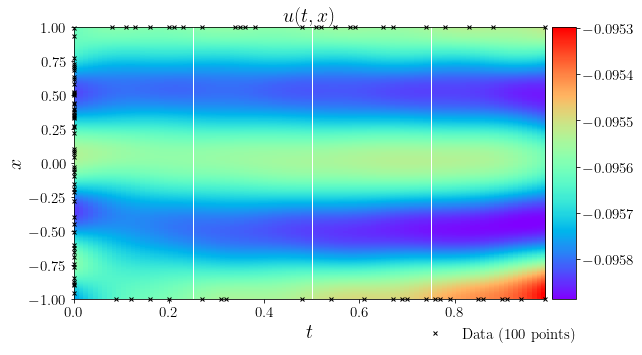

In [11]:
#画图，基本摘抄原作者TensorFlow版
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) 
ax.tick_params(labelsize=15)

plt.show()

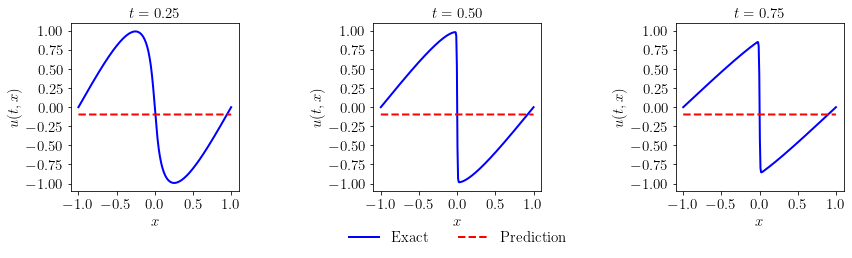

In [12]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()